**Enhanced Landslide Detection Using
Spatial-Channel Attention with ResNet50**

A major worldwide danger, landslides cause enormous
losses in terms of both life and property. The accuracy
and scalability of traditional landslide detection techniques are
frequently lacking, particularly in areas with complicated topography
like northern Pakistan. For accurate landslide detection,
this study introduces an improved convolutional neural network
(CNN) model that combines spatial-channel attention methods
with ResNet50. With improved accuracy and interpretability,
the suggested model performs noticeably better than the current
state-of-the-art models. Additionally, dynamic visualizations of
Gradio provide end users with a useful interface.

LOADING THE DATASET FROM KAGGLE

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hanstankman/bijie-landslidedataset")

print("Path to dataset files:", path)


100%|██████████| 502M/502M [00:29<00:00, 17.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hanstankman/bijie-landslidedataset/versions/1


IMPORTING NECCESSARY LIBRARIES

In [ ]:
import os
import numpy as np
import cv2
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50,deeplabv3_resnet101
from PIL import Image
from tqdm import tqdm
from torch import optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.segmentation as segmentation
#Migrate model import damei
from torchvision.models import vgg13, vgg16, vgg19, resnet18, resnet50, resnet101, resnet152, inception_v3, densenet121, densenet169, densenet201

**IMAGE ENHANCEMENTS AND AUGMENTATION**

This cell provides a set of functions for enhancing images in various ways, including loading and resizing images, adding Gaussian or salt-and-pepper noise to simulate real-world distortions, and improving contrast using histogram equalization. The resize_and_normalize function scales images to a target size and normalizes pixel values, while add_noise and salt_and_pepper_noise introduce randomness to pixel intensities for robustness testing. The histogram_equalization function enhances details by redistributing brightness levels through the Y channel of the YUV color space. These tools are essential for preprocessing and augmenting datasets in computer vision tasks.

In [ ]:
##Data enhancement operations
def load_image(file_path):
    return np.array(Image.open(file_path))

def resize_and_normalize(image, target_size, max_value=255.0):
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    image = (image - image.min()) / (image.max() - image.min()) * max_value
    return image.astype(np.uint8)

def add_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss * 255
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

def salt_and_pepper_noise(image, amount=0.004):
    row, col, ch = image.shape
    s_vs_p = 0.5
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords[0], coords[1], :] = 1

    # Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords[0], coords[1], :] = 0
    return out

def histogram_equalization(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

This cell sets up a PyTorch pipeline for loading and preprocessing the Bijie Landslide Dataset, combining images, DEM (Digital Elevation Model) data, and segmentation masks for landslide analysis. It defines a custom dataset class that loads and resizes images and DEMs, aligns them, and handles masks, even for non-landslide data by creating zero masks. A transform function applies random augmentations, resizes inputs to 224x224, normalizes using standard values, and fuses image and DEM channels for richer input data. Finally, the dataset is instantiated and tested, demonstrating its use for tasks like semantic segmentation, where multimodal data improves predictions.

In [ ]:
import os
import torch
import random
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms as T
from PIL import Image

# Step 1: Mount Google Drive if dataset is in Drive (optional)
#from google.colab import drive
#drive.mount('/content/drive')

# Step 2: Download or copy the dataset
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
# Upload your Kaggle API token (kaggle.json) to Colab
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Bijie Landslide Dataset
!kaggle datasets download -d hanstankman/bijie-landslidedataset
!unzip bijie-landslidedataset.zip -d /content/bijie-landslidedataset

# Verify the path to the dataset
root_dir = "/content/bijie-landslidedataset/Bijie-landslide-dataset/landslide"

# Step 3: Data processing - Dataset class
class BijieLandslideDataset(Dataset):
    def __init__(self, root_dir, phase='train', transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_dir = os.path.join(root_dir, 'image')
        self.dem_dir = os.path.join(root_dir, 'dem')
        self.mask_dir = os.path.join(root_dir, 'mask') if phase != 'non-landslide' else None

        # Check if directories exist
        assert os.path.exists(self.image_dir), f"Image directory not found: {self.image_dir}"
        assert os.path.exists(self.dem_dir), f"DEM directory not found: {self.dem_dir}"
        if self.mask_dir:
            assert os.path.exists(self.mask_dir), f"Mask directory not found: {self.mask_dir}"

        self.images = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        self.dems = [f for f in os.listdir(self.dem_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        dem_path = os.path.join(self.dem_dir, self.images[idx])

        img = np.array(Image.open(img_path).convert("RGB"))
        dem = np.array(Image.open(dem_path).convert("L"))

        # Resize DEM to match image dimensions
        dem = np.array(Image.fromarray(dem).resize(img.shape[1::-1]))

        if self.mask_dir:
            mask_path = os.path.join(self.mask_dir, self.images[idx])
            mask = np.array(Image.open(mask_path).convert("L"))
        else:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)

        sample = {'image': img, 'dem': dem, 'mask': mask}

        if self.transforms:
            sample = self.transforms(sample)

        return sample

# Step 4: Transform function
def transform(sample):
    image, dem, mask = sample['image'], sample['dem'], sample['mask']

    # Augmentations
    if random.random() > 0.5:
        image = np.fliplr(image)
        dem = np.fliplr(dem)
        mask = np.fliplr(mask)

    # Data fusion and preprocessing
    image = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(image)

    dem = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ])(dem)

    mask = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=Image.NEAREST),
        T.ToTensor()
    ])(mask)

    return {'image': torch.cat((image, dem), dim=0), 'mask': mask}

# Step 5: Instantiate the dataset and test
dataset = BijieLandslideDataset(root_dir=root_dir, transforms=transform)

# Test dataset loading
print("Number of samples in dataset:", len(dataset))
sample = dataset[0]
print("Sample image shape:", sample['image'].shape)
print("Sample mask shape:", sample['mask'].shape)


Streaming output truncated to the last 5000 lines.
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg098.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg099.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg100.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg101.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg102.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg103.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg104.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg105.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landslide/mask/qxg106.png  
  inflating: /content/bijie-landslidedataset/Bijie-landslide-dataset/landsli

In [ ]:
pip install torchsummary

thop (Torch-Op Counter) is a PyTorch-based library that calculates the number of FLOPs (floating point operations) and parameters of a neural network model. It is useful for analyzing the computational complexity and size of models.

In [ ]:
pip install thop

**Efficient Channel Attention (ECA)**

The script implements the Efficient Channel Attention (ECA) mechanism, which adaptively assigns importance to different feature channels in convolutional neural networks. It uses global average pooling to summarize spatial information, a lightweight 1D convolution to capture channel dependencies, and a sigmoid activation to generate attention weights. These weights are multiplied with the input feature map to enhance relevant features. The model is initialized using He initialization for stability and tested for its computational efficiency using torchsummary and thop. With minimal parameters 4 and low computational cost (45.31K FLOPs), ECAAttention provides an efficient way to boost network performance without significant overhead

In [ ]:
#Attention mechanismECA
import torch
from torch import nn
from torch.nn import init

class ECAAttention(nn.Module):

    def __init__(self, kernel_size=3):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.sigmoid = nn.Sigmoid()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.gap(x)
        y = y.squeeze(-1).permute(0, 2, 1)
        y = self.conv(y)
        y = self.sigmoid(y)
        y = y.permute(0, 2, 1).unsqueeze(-1)
        return x * y.expand_as(x)
if __name__ == '__main__':
    from  torchsummary import summary
    from thop import profile
    model = ECAAttention(kernel_size=3)
    summary(model, (512, 7, 7), device='cpu')
    flops, params = profile(model, inputs=(torch.randn(1, 512, 7, 7),))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1            [-1, 512, 1, 1]               0
            Conv1d-2               [-1, 1, 512]               4
           Sigmoid-3               [-1, 1, 512]               0
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.11
----------------------------------------------------------------
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.


**MODEL PREPARATION**

This cell implements a custom ResNet-50 architecture with modifications, including the integration of ECA Attention for channel-wise feature enhancement and an Upsample and Reduce Channels module for adapting feature maps to a specific output size (224x224) with reduced channels. The bottleneck blocks form the core of the architecture, featuring three convolutional layers (1x1, 3x3, and 1x1) with batch normalization, ReLU activation, and shortcut connections for efficient gradient flow. The model replaces the standard ResNet classification head with a CustomModel module that flattens the output after upsampling and channel reduction for final classification. Using modular **_make_layer** functions, it builds the five convolutional layers (conv1 to conv5) of ResNet, ensuring scalability and adaptability. The script also employs **nn.DataParallel** to enable multi-GPU training, making the model suitable for tasks requiring efficient feature extraction and attention mechanisms.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=[1,1,1], padding=[0,1,0], first=False):
        super(Bottleneck, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride[0], padding=padding[0], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride[1], padding=padding[1], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=stride[2], padding=padding[2], bias=False),
            nn.BatchNorm2d(out_channels * 4),
        )
        self.shortcut = nn.Sequential()
        if first:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride[1], bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        self.eca_attention = ECAAttention(kernel_size=3)

    def forward(self, x):
        out = self.bottleneck(x)
        out += self.shortcut(x)
        out = self.eca_attention(out)
        return F.relu(out)

class UpsampleAndReduceChannels(nn.Module):
    def __init__(self, in_channels, out_channels, output_size):
        super(UpsampleAndReduceChannels, self).__init__()
       # Define a 1x1 convolutional layer to reduce the number of channels from in_channels to out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.output_size = output_size

    def forward(self, x):
       # Upsample to the specified output size
        x = F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)
        # Reduce the number of channels through convolutional layers
        x = self.conv(x)
        return x

class CustomModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomModel, self).__init__()
        # Define a module that reduces the number of channels from 2048 to 3 and upsamples to 224x224
        self.upsample_and_reduce = UpsampleAndReduceChannels(2048, 2, (224, 224))
        # Define the subsequent fully connected layer, assuming that the classification task will eventually be carried out
        self.fc = nn.Linear(2 * 224 * 224, num_classes)

    def forward(self, x):
        # Reduce modules by upsampling and channel count
        x = self.upsample_and_reduce(x)
        # Flatten the tensor
#         x = x.view(x.size(0), -1)
#        # Classification through fully connected layer
#         x = self.fc(x)
        return x

# In the network using bn, the output of the convolutional layer is not biased
class ResNet50(nn.Module):
    def __init__(self,Bottleneck, num_classes=2) -> None:
        super(ResNet50, self).__init__()
        self.in_channels = 64
       # The first layer is used as a separate layer because it is not as fast as the residual
        self.conv1 = nn.Sequential(
            nn.Conv2d(4,64,kernel_size=7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # conv2
        self.conv2 = self._make_layer(Bottleneck,64,[[1,1,1]]*3,[[0,1,0]]*3)

        # conv3
        self.conv3 = self._make_layer(Bottleneck,128,[[1,2,1]] + [[1,1,1]]*3,[[0,1,0]]*4)

        # conv4
        self.conv4 = self._make_layer(Bottleneck,256,[[1,2,1]] + [[1,1,1]]*5,[[0,1,0]]*6)

        # conv5
        self.conv5 = self._make_layer(Bottleneck,512,[[1,2,1]] + [[1,1,1]]*2,[[0,1,0]]*3)

        self.CustomModel =CustomModel()
        # You can add other layers here, such as fully connected layers
        self.fc = nn.Linear(2 * 224 * 224, 2)  #·The number of output categories is 2

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self,block,out_channels,strides,paddings):
        layers = []
        # Used to determine whether it is the first layer of each block layer
        flag = True
        for i in range(0,len(strides)):
            layers.append(block(self.in_channels,out_channels,strides[i],paddings[i],first=flag))
            flag = False
            self.in_channels = out_channels * 4


        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.CustomModel(out)

#         out = self.avgpool(out)
#         out = out.reshape(x.shape[0], -1)
#         out = self.fc(out)
        return out

model = ResNet50(Bottleneck)
model = nn.DataParallel(model)

**Split data**

This code splits a dataset into training and validation subsets using train_test_split, with 33% of the data allocated to the validation set and the split controlled by a fixed random_state for reproducibility. It creates Subset objects for both training and validation sets and initializes corresponding DataLoader instances. The **train_loader** shuffles data for better generalization during training, while the **val_loader** maintains a consistent order for evaluation. Both loaders process data in batches of size 8 and use **num_workers=4 **to enable parallel data loading, ensuring efficient handling of data during model training and validation.

In [ ]:
# Split data
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.33, random_state=42)

train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


This script implements the training and validation loops for a segmentation model using PyTorch. It employs the CrossEntropyLoss function for multi-class classification tasks, and the Adam optimizer with a learning rate of 0.0001 to update model parameters. The train_one_epoch function trains the model for one epoch, computing running loss and accuracy on the training data while displaying progress via tqdm. Similarly, the validate function evaluates the model on the validation data without updating parameters. Both functions record epoch-level loss and accuracy. A calculate_accuracy helper function computes accuracy by comparing predictions with ground truth labels. The training process spans 20 epochs, storing loss and accuracy for both training and validation phases in lists for later analysis. The model is trained on a GPU if available, ensuring efficient computation.

In [ ]:
import torch
from torch import optim
from tqdm import tqdm


criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc
def train_one_epoch(epoch, model, dataloader, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Training")
    for batch in progress_bar:
        inputs = batch['image'].to(device)
        masks = batch['mask'].to(device, dtype=torch.long).squeeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        acc = calculate_accuracy(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += acc.item()
        progress_bar.set_postfix({'Training Loss': f"{loss.item():.4f}", 'Accuracy': f"{acc.item():.4f}"})
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    print(f"Epoch {epoch} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    torch.cuda.empty_cache()
    return epoch_loss, epoch_accuracy
def validate(epoch, model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Validation")
    with torch.no_grad():
        for batch in progress_bar:
            inputs = batch['image'].to(device)
            masks = batch['mask'].to(device, dtype=torch.long).squeeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            acc = calculate_accuracy(outputs, masks)
            running_loss += loss.item()
            running_accuracy += acc.item()
            progress_bar.set_postfix({'Validation Loss': f"{loss.item():.4f}", 'Accuracy': f"{acc.item():.4f}"})
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    print(f"Epoch {epoch} Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy

# Record loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Training cycle
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, device)
    val_loss, val_acc = validate(epoch, model, val_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 1 Training: 100%|██████████| 65/65 [02:21<00:00,  2.17s/it, Training Loss=0.1665, Accuracy=0.9180]


Epoch 1 Training Loss: 0.2415, Accuracy: 0.8982


Epoch 1 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.55it/s, Validation Loss=0.1650, Accuracy=0.9352]


Epoch 1 Validation Loss: 0.1887, Accuracy: 0.9216


Epoch 2 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1146, Accuracy=0.9552]


Epoch 2 Training Loss: 0.1783, Accuracy: 0.9216


Epoch 2 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s, Validation Loss=0.1891, Accuracy=0.9102]


Epoch 2 Validation Loss: 0.1985, Accuracy: 0.9182


Epoch 3 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.2395, Accuracy=0.9059]


Epoch 3 Training Loss: 0.1736, Accuracy: 0.9245


Epoch 3 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.41it/s, Validation Loss=0.1660, Accuracy=0.9225]


Epoch 3 Validation Loss: 0.1756, Accuracy: 0.9254


Epoch 4 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1713, Accuracy=0.9174]


Epoch 4 Training Loss: 0.1657, Accuracy: 0.9280


Epoch 4 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, Validation Loss=0.1502, Accuracy=0.9322]


Epoch 4 Validation Loss: 0.1677, Accuracy: 0.9291


Epoch 5 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1662, Accuracy=0.9234]


Epoch 5 Training Loss: 0.1568, Accuracy: 0.9325


Epoch 5 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.25it/s, Validation Loss=0.1498, Accuracy=0.9333]


Epoch 5 Validation Loss: 0.1599, Accuracy: 0.9333


Epoch 6 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.2053, Accuracy=0.8916]


Epoch 6 Training Loss: 0.1472, Accuracy: 0.9364


Epoch 6 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s, Validation Loss=0.1453, Accuracy=0.9397]


Epoch 6 Validation Loss: 0.1506, Accuracy: 0.9364


Epoch 7 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0940, Accuracy=0.9650]


Epoch 7 Training Loss: 0.1413, Accuracy: 0.9389


Epoch 7 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.50it/s, Validation Loss=0.1316, Accuracy=0.9392]


Epoch 7 Validation Loss: 0.1454, Accuracy: 0.9393


Epoch 8 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1447, Accuracy=0.9427]


Epoch 8 Training Loss: 0.1319, Accuracy: 0.9442


Epoch 8 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s, Validation Loss=0.1356, Accuracy=0.9404]


Epoch 8 Validation Loss: 0.1391, Accuracy: 0.9413


Epoch 9 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1193, Accuracy=0.9495]


Epoch 9 Training Loss: 0.1255, Accuracy: 0.9464


Epoch 9 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s, Validation Loss=0.1263, Accuracy=0.9429]


Epoch 9 Validation Loss: 0.1325, Accuracy: 0.9435


Epoch 10 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0971, Accuracy=0.9576]


Epoch 10 Training Loss: 0.1206, Accuracy: 0.9484


Epoch 10 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s, Validation Loss=0.1226, Accuracy=0.9483]


Epoch 10 Validation Loss: 0.1325, Accuracy: 0.9430


Epoch 11 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1248, Accuracy=0.9437]


Epoch 11 Training Loss: 0.1151, Accuracy: 0.9508


Epoch 11 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.44it/s, Validation Loss=0.1342, Accuracy=0.9397]


Epoch 11 Validation Loss: 0.1382, Accuracy: 0.9419


Epoch 12 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.1265, Accuracy=0.9379]


Epoch 12 Training Loss: 0.1125, Accuracy: 0.9521


Epoch 12 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s, Validation Loss=0.1282, Accuracy=0.9434]


Epoch 12 Validation Loss: 0.1234, Accuracy: 0.9491


Epoch 13 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0747, Accuracy=0.9692]


Epoch 13 Training Loss: 0.1084, Accuracy: 0.9542


Epoch 13 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.45it/s, Validation Loss=0.1290, Accuracy=0.9398]


Epoch 13 Validation Loss: 0.1294, Accuracy: 0.9469


Epoch 14 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0876, Accuracy=0.9610]


Epoch 14 Training Loss: 0.1077, Accuracy: 0.9541


Epoch 14 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s, Validation Loss=0.1354, Accuracy=0.9384]


Epoch 14 Validation Loss: 0.1297, Accuracy: 0.9466


Epoch 15 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0807, Accuracy=0.9629]


Epoch 15 Training Loss: 0.1039, Accuracy: 0.9557


Epoch 15 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Validation Loss=0.1227, Accuracy=0.9473]


Epoch 15 Validation Loss: 0.1256, Accuracy: 0.9491


Epoch 16 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.2254, Accuracy=0.9064]


Epoch 16 Training Loss: 0.1012, Accuracy: 0.9573


Epoch 16 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.25it/s, Validation Loss=0.1325, Accuracy=0.9406]


Epoch 16 Validation Loss: 0.1254, Accuracy: 0.9498


Epoch 17 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0781, Accuracy=0.9672]


Epoch 17 Training Loss: 0.0975, Accuracy: 0.9582


Epoch 17 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s, Validation Loss=0.1169, Accuracy=0.9457]


Epoch 17 Validation Loss: 0.1245, Accuracy: 0.9490


Epoch 18 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0742, Accuracy=0.9691]


Epoch 18 Training Loss: 0.0910, Accuracy: 0.9614


Epoch 18 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s, Validation Loss=0.1210, Accuracy=0.9517]


Epoch 18 Validation Loss: 0.1169, Accuracy: 0.9537


Epoch 19 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0729, Accuracy=0.9674]


Epoch 19 Training Loss: 0.0870, Accuracy: 0.9629


Epoch 19 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s, Validation Loss=0.1230, Accuracy=0.9456]


Epoch 19 Validation Loss: 0.1206, Accuracy: 0.9509


Epoch 20 Training: 100%|██████████| 65/65 [02:19<00:00,  2.14s/it, Training Loss=0.0606, Accuracy=0.9760]


Epoch 20 Training Loss: 0.0853, Accuracy: 0.9641


Epoch 20 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s, Validation Loss=0.1404, Accuracy=0.9405]

Epoch 20 Validation Loss: 0.1185, Accuracy: 0.9519


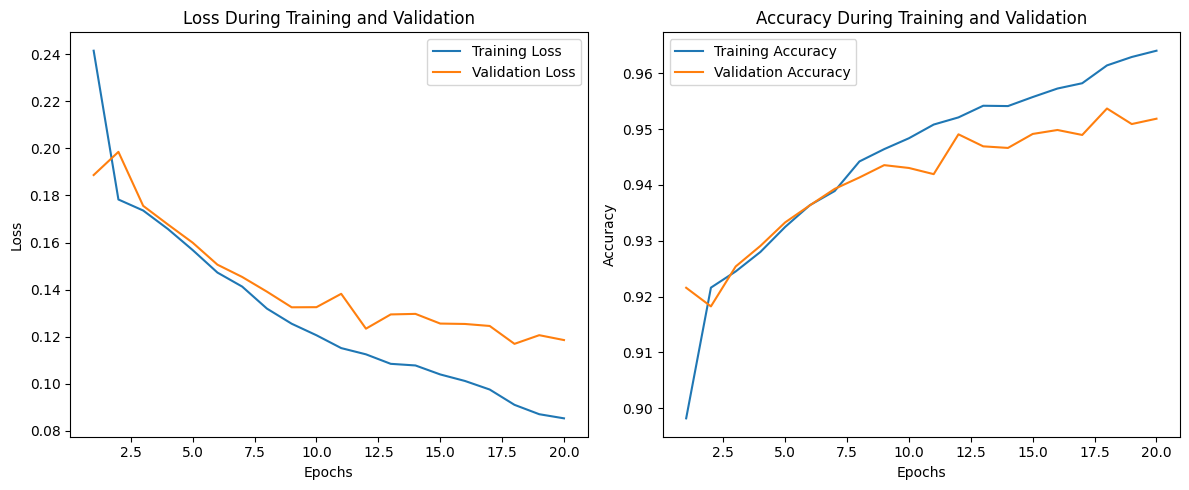

In [ ]:
# drawing graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training and Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training and Validation')
plt.legend()

plt.tight_layout()
plt.show()


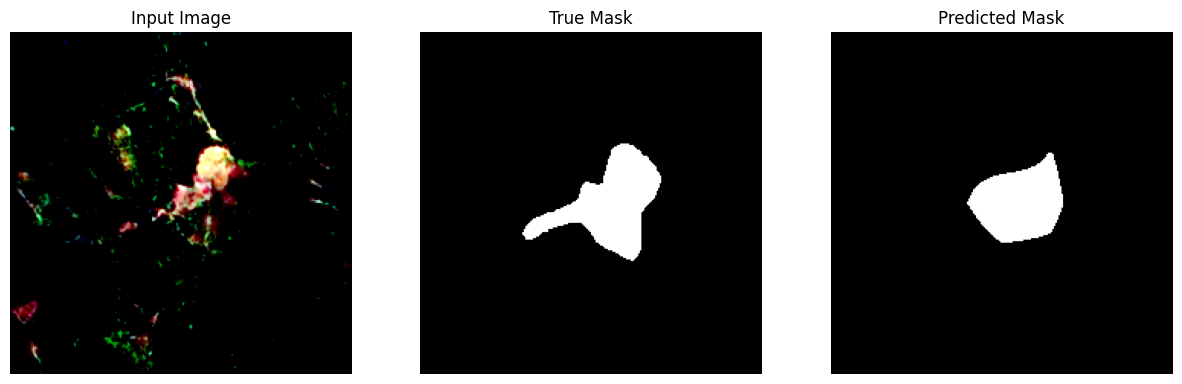

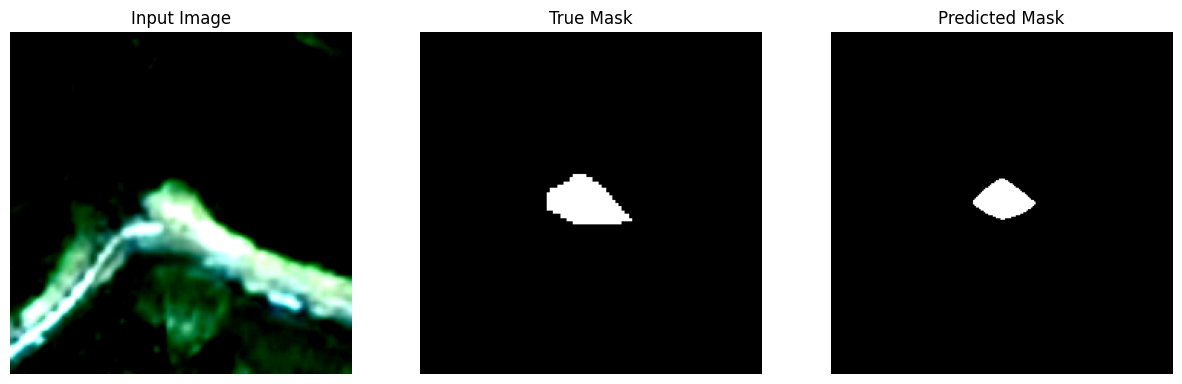

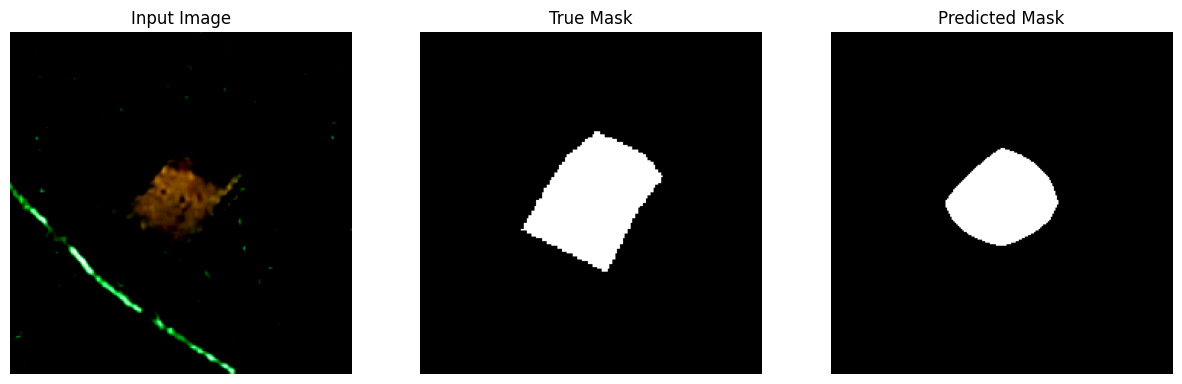

In [ ]:
def visualize_predictions(dataset, model, device, num_examples=3):
    model.eval()
   # Select several samples to show the prediction effect
    samples = torch.utils.data.Subset(dataset, range(num_examples))
    loader = DataLoader(samples, batch_size=1, shuffle=False)

    with torch.no_grad():
        for i, batch in enumerate(loader):
            # Go to GPU
            inputs = batch['image'].to(device)
            # Get real mask data and convert it to numpy
            true_masks = batch['mask'].squeeze(1).numpy()
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy() # Select the category with the highest probability as the prediction result
            # pltdraw
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.title('Input Image')
            plt.imshow(inputs.cpu().numpy()[0][0:3].transpose(1, 2, 0))
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title('True Mask')
            plt.imshow(true_masks[0], cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(preds[0], cmap='gray')
            plt.axis('off')

            plt.show()

visualize_predictions(val_subset, model, device, num_examples=3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/bijie_landslide_model.pth")
print("Model saved to Google Drive!")


Mounted at /content/drive
Model saved to Google Drive!


In [ ]:
import gradio as gr
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

# Assuming you have the model and dataset properly set up
model = ResNet50(Bottleneck)  # Replace with your actual model definition
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/content/drive/MyDrive/bijie_landslide_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])  # Normalize for 4 channels
])

# Define a function to handle the input and output for Gradio
def visualize_segmentation(image):
    try:
        # Convert the image to RGBA (4 channels)
        image = image.convert('RGBA')

        # Apply the transformations
        input_tensor = transform(image).unsqueeze(0)  # Add batch dimension (batch_size, C, H, W)

        # Move the tensor to the correct device
        device = torch.device("cpu")
        input_tensor = input_tensor.to(device)

        # Perform inference (forward pass)
        with torch.no_grad():
            output = model(input_tensor)

        output = torch.nn.functional.softmax(output, dim=1)
        preds = torch.argmax(output, dim=1).cpu().numpy()  # Predicted mask

        # Assuming the true mask is available for visualization (you can replace it with a dummy mask if not available)
        true_masks = np.zeros_like(preds)  # Dummy true mask for visualization (replace with actual mask if available)

        # Prepare the plot for visualization
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(input_tensor.cpu().numpy()[0][0:3].transpose(1, 2, 0))
        axs[0].set_title('Input Image')
        axs[0].axis('off')

        axs[1].imshow(true_masks[0], cmap='gray')
        axs[1].set_title('True Mask')
        axs[1].axis('off')

        axs[2].imshow(preds[0], cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')

        # Save the plot to a file (for Gradio to display it)
        plt.tight_layout()
        plt.savefig('/tmp/segmentation_output.png')
        plt.close()

        # Return the saved plot image for display
        return '/tmp/segmentation_output.png'

    except Exception as e:
        return f"Error: {str(e)}"

# Create the Gradio interface
iface = gr.Interface(
    fn=visualize_segmentation,  # The function that processes the image and visualizes the output
    inputs=gr.Image(type="pil"),  # Input is an image file (PIL format)
    outputs="image",  # Output is an image (the plot with 3 subplots)
    live=True  # Live updates when input is changed
)

# Launch the interface
iface.launch()


<ipython-input-32-6e1b9398bb65>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/bijie_landslide_model.pth', map_lo

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a9e67c6afc8c6d8ddf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
